<a href="https://colab.research.google.com/github/Kuwar123/Fake_news_detection/blob/main/Fake_news_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fake and Real news Detection using LSTM and Deep Learning


Library Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

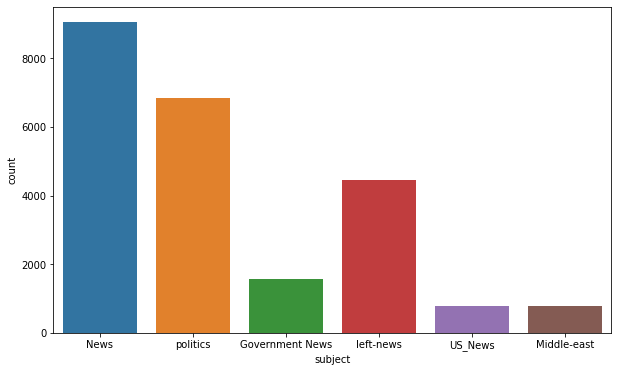

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)


WordCloud

In [ ]:
text = ' '.join(fake['text'].tolist())

In [ ]:
', '.join(['this','is','a','data'])

'this, is, a, data'

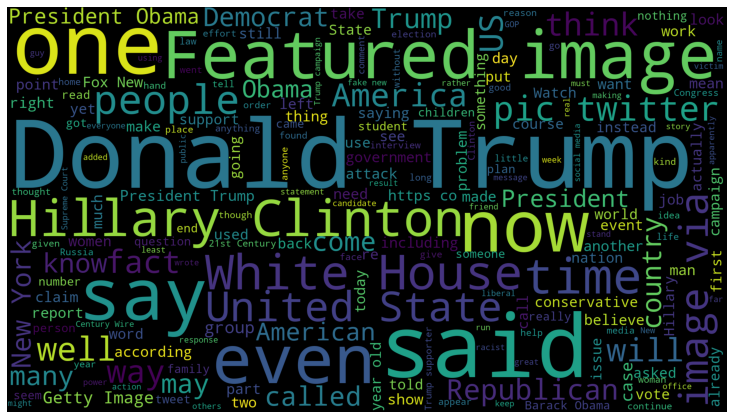

In [ ]:
wordcloud = WordCloud(width=1920,height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Exploring Real news

In [ ]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [ ]:
text = ' '.join(real['text'].tolist())

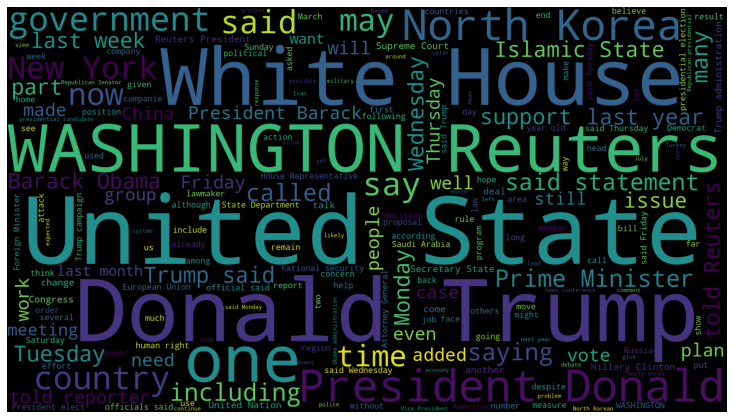

In [ ]:
wordcloud = WordCloud(width=1920,height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Cleaning Data

In [ ]:
real.sample(5)

,text,class
11117,"watch out frontrunners, over 1,500 candidates ...",1
1805,mexico foreign minister heads to u.s. to meet ...,1
11592,cardinal law funeral held at vatican with no m...,1
19067,turnout high as iraqi kurds defy threats to ho...,1
16936,former nazi death camp guard charged with acce...,1


In [ ]:
unknown_publishers = []
for index ,row in enumerate(real.text.values):
  try:
    record = row.split('-',maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)  

In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real = real.drop(8970,axis=0)

In [ ]:
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    
  else:
    record = row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())


In [ ]:
real['publisher'] = publisher
real['text'] = tmp_text

In [ ]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
real.shape

(21416, 5)

In [ ]:
empty_fake_index = [index for  index,text in enumerate(fake.text.to_list()) if str(text).strip()==""]

In [ ]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [ ]:
real['text'] = real['text'].apply(lambda x:str(x).lower())
fake['text'] = fake['text'].apply(lambda x:str(x).lower())


Preprocessing Text

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real = real[['text','class']]

In [ ]:
fake = fake[['text','class']]

In [ ]:
data = real.append(fake,ignore_index=True)

In [ ]:
data.sample(5)

,text,class
41076,obama’s communist crony van jones worries abou...,0
43511,is the united states of america a liberal demo...,0
23836,kansas tea party governor gets his a** handed...,0
29544,cruz humiliated by moderator after lie about ...,0
20821,trump seeks tougher sanctions to prod north ko...,1


In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 12.0 MB 4.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-7lpnuw45
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-7lpnuw45
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11754 sha256=47d24ad157c65fc77bf6f0799180f75476449b749193c0c5e55ed82349b21cfe
  Stored in directory: /tmp/pip-ephem-wheel-cache-ebuw9c2u/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
data['text']=data['text'].apply(lambda x :ps.remove_special_chars(x))

In [ ]:
ps.remove_special_chars('this ,. @ # is great')

'this is great'

In [ ]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


In [ ]:
import gensim

In [ ]:
y = data['class'].values

In [ ]:
X = [d.split() for d in data['text'].tolist()]

In [ ]:
type(X[0])

list

In [ ]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [ ]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X,size=DIM,window=10,min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

231872

In [ ]:
w2v_model.wv['love']

array([ 5.2716654e-02, -2.5461693e+00, -8.7324238e-01,  2.1229007e+00,
        2.7307159e-01, -9.0122715e-02, -1.1712404e+00, -3.0956224e-01,
        6.0949421e-01, -5.3904611e-01,  1.4966683e-03,  5.1700458e-02,
        5.1932448e-01, -3.7212200e-02, -4.6568050e+00, -1.1317750e+00,
        7.1027350e-01, -1.1821831e-01,  2.6431048e+00,  3.0971918e+00,
        1.2472982e-01, -1.3693331e+00,  1.5518630e-01,  2.8470910e-01,
       -2.2858913e+00,  2.9841864e+00,  2.7918751e+00, -2.3645167e+00,
        2.3439269e-01, -3.6596067e+00, -5.1646936e-01,  7.8693360e-01,
       -2.9778788e+00,  3.0424032e+00,  5.9381253e-01,  2.3232074e+00,
       -5.9951085e-01,  2.4136450e+00,  2.3872406e+00,  2.5401437e+00,
       -4.9999440e-01, -3.1433051e+00,  2.7923162e+00, -1.4079425e+00,
       -1.7954930e+00,  1.7885759e-01,  2.8358321e+00,  2.6934552e+00,
        1.7098402e+00, -4.0703300e-01,  5.9528446e-01,  1.6608642e+00,
       -6.9291592e-01,  2.3540182e+00,  7.1390554e-02,  4.3784361e+00,
      

In [ ]:
w2v_model.wv.most_similar('trump')

[('trumps', 0.7409123182296753),
 ('he', 0.5641866326332092),
 ('cruz', 0.543621301651001),
 ('him', 0.5374389290809631),
 ('trumpthe', 0.536657452583313),
 ('trumptrump', 0.5299726724624634),
 ('presidentelect', 0.5230939388275146),
 ('trumphere', 0.5222015976905823),
 ('pentagonironically', 0.5137470960617065),
 ('rubio', 0.5030457377433777)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

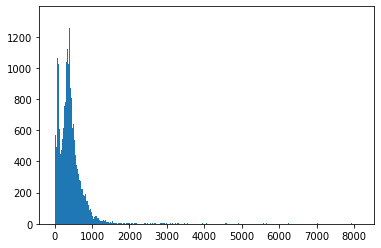

In [ ]:
plt.hist([len(x) for x in X],bins = 700)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1581

In [ ]:
maxlen = 1000
X = pad_sequences(X,maxlen=maxlen)

In [ ]:
len(X[101])

1000

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size,DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix


In [ ]:
 embedding_vectors =get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

(231873, 100)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights = [embedding_vectors],input_length=maxlen,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 100)         23187300  
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,304,677
Trainable params: 117,377
Non-trainable params: 23,187,300
_________________________________________________________________


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [ ]:
model.fit(X_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
737/737 [==============================] - 130s 166ms/step - loss: 0.1309 - acc: 0.9521 - val_loss: 0.0563 - val_acc: 0.9797
Epoch 2/6
737/737 [==============================] - 122s 165ms/step - loss: 0.0477 - acc: 0.9842 - val_loss: 0.0466 - val_acc: 0.9837
Epoch 3/6
737/737 [==============================] - 122s 165ms/step - loss: 0.0354 - acc: 0.9877 - val_loss: 0.0447 - val_acc: 0.9844
Epoch 4/6
737/737 [==============================] - 122s 166ms/step - loss: 0.0169 - acc: 0.9943 - val_loss: 0.0277 - val_acc: 0.9911
Epoch 5/6
737/737 [==============================] - 128s 173ms/step - loss: 0.0339 - acc: 0.9898 - val_loss: 0.0278 - val_acc: 0.9910
Epoch 6/6
737/737 [==============================] - 122s 166ms/step - loss: 0.0118 - acc: 0.9966 - val_loss: 0.0411 - val_acc: 0.9878


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [ ]:
accuracy_score(y_test,y_pred)

0.9877951002227171

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5868
           1       1.00      0.98      0.99      5357

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
x = ['this is a news']

In [ ]:
X_test

array([[     0,      0,      0, ...,    197,    175,   4125],
       [     0,      0,      0, ...,    197,    175,   3827],
       [     0,      0,      0, ...,    102,    600,    152],
       ...,
       [     0,      0,      0, ...,   5341,    169,    560],
       [     0,      0,      0, ...,      1,  61833, 107572],
       [     0,      0,      0, ...,      2,     22,    446]], dtype=int32)

In [ ]:
x = ['this is a news']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=maxlen)


In [ ]:
(model.predict(x) >= 0.5).astype(int)

array([[0]])

In [ ]:
x =  ['As many as 11,271 new COVID-19 cases and 285 Covid deaths were also reported in the country in the last 24 hours. The death toll from the virus has now reached 4,63,530, the ministry informed.']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=maxlen)
(model.predict(x) >= 0.5).astype(int)

array([[1]])